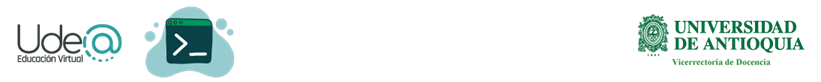

---
# Laboratorio Regresión Lineal
## **Parte A:** estimación de parámetros y sobre-entrenamiento

**Laboratorio Tratamiento de Señales III** *Práctica* 08

**Laboratorio: Laboratorio Segmentación de Imágenes**

*   Mateo Muñoz Arroyave
CC 1036676919

*   David Esteban Londoño Patiño
CC 1020465536

**Facultad de Ingeniería**

**Universidad de Antioquia**

**Autor: Pablo Alejandro Alvarado Duran**

---
# Introducción a regresión lineal
 La Regresión Lineal (RL) consiste en encontrar una función $f$ que establezca una regla de correspondencia entre los datos de entrada $\textbf{x}_n$ con los datos de salida $y_n$ de manera que

 $$y_n = f(\textbf{x}_n),$$

 donde las entradas $\textbf{x}_n \in \mathbb{R}^D$, y las salidas $y_n \in \mathbb{R}$.

 Regresión es un tema central en inteligencia artificial, reconocimiento de patrones, y aprendizaje de máquina. RL tiene aplicaciones en análisis de series de tiempo, control, robótica, optimización y aprendizaje profundo.

In [1]:
import numpy as np
import scipy as sp
import sklearn as skl
import matplotlib.pyplot as plt

## Cómo se mide el desempeño de un modelo de regresión?
 Que un modelo sea *bueno* o no depende de su capacidad de **generalización**, es decir, que prediga de forma precisa los valores de la función $f$ donde hay observaciones $\textbf{x}_n$, así como en partes del espacio entrada donde no hay mediciones o datos.


## Cómo solucionar un problema de regresión lineal?
En general, solucionar un problema de regresión lineal requiere:

1. **Escoger el modelo y su parametrización**

 Qué clase de funciones se van usar o cuáles son buenas candidatas? (ej. funciones polinomiales), y sus parámetros (ej. grado orden del polinomio).

2. **Encontrar los parámetros adecuados (inferencia)**

 Cómo encontramos los parámetros adecuados para que el modelo se ajuste bien a los datos? Las **funciones objetivo** determinan o miden que tan bien se ajusta un modelo a los datos. Por otro lado, los **algoritmos de optimización** nos permiten encontrar los valores de los parámetros que minimizan la función objetivo, esto se conoce como **inferencia**.

3. **Evaluar el desempeño del modelo**

 El sobreentrenamiento (overfitting) ocurre cuando el modelo se ajusta muy bien a los datos de entrenamiento (observaciones) pero no a los datos de test (no observados). Esto ocurre, por lo general, cuando el modelo es demasiado flexible o complejo.

En la **parte A** este laboratorio con enfocaremos en la definición de modelos de regresión, como inferir sus parámetros, y cómo medir la calidad de las predicciones. Luego, en la **parte B** vamos a analizar las causas del sobreentrenamiento y cómo mitigarlo con regularización y regresión Bayesiana.

---
# Selección del modelo y parametrización
Cómo punto de partida consideraremos el modelo de regresión lineal de la forma

$$
\begin{align}
y &= \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_D x_D, \\
y &= \sum_{i=0}^{D}\theta_{i}x_i, \\
y &= \textbf{x}^\top\boldsymbol\theta, \\
y &= f(\textbf{x},\boldsymbol\theta).
\end{align}
$$

Si además adicionamos ruido o incertidumbre en las mediciones, obtenemos

$$
y = \textbf x^\top\boldsymbol\theta + \epsilon\,,\quad \epsilon \sim \mathcal N\left(0, \sigma^2\right)
$$

donde $\textbf x \in \mathbb R^D$ son las entradas, mientras que $ y \in \mathbb R$ son las observaciones ruidosas de salida. Además, el vector de parámetros $\boldsymbol \theta \in \mathbb R ^D$ define la forma específica de la función $f$.

Se asume que tenemos un conjunto de datos de entrenamiento $(\textbf x_n, y_n)$ para $n=1,\ldots, N$, de manera que agrupamos los conjuntos de datos de entrada y de salida como $\mathcal X = \{\textbf x_1, \ldots, \textbf x_N\}$, $\mathcal Y = \{y_1, \ldots, y_N\}$. Nuestro objetivo es encontrar valores apropiados para los parámetros $\boldsymbol\theta$ dada la base de datos $\{ \mathcal X, \mathcal Y \}$.

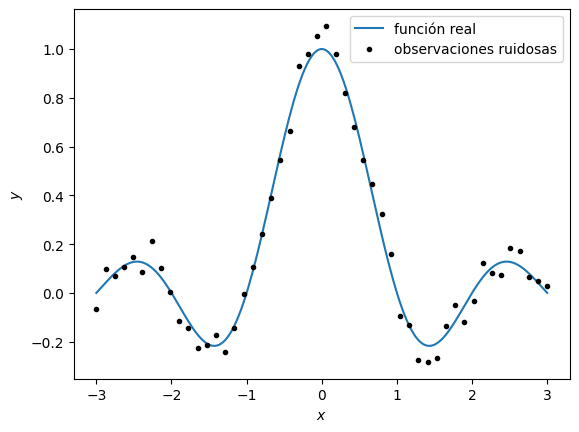

In [2]:
# generar base de datos sintética
X = np.linspace(-3, 3, 50).reshape(-1, 1)
y = np.sinc(X) + 0.05*np.random.normal(size=(X.shape))

xfun = np.linspace(-3, 3, 200).reshape(-1, 1)
yfun = np.sinc(xfun)

plt.plot(xfun, yfun)
plt.plot(X, y, '.k')
plt.xlabel("$x$")
plt.ylabel("$y$");
plt.legend(['función real', 'observaciones ruidosas'])

## Qué significa *lineal* en regresión lineal?
 En este contexto, la palabra *lineal* hace referencia a que el modelo (función a ajustar) es lineal con respecto a los parámetros $\boldsymbol{\theta}$, es decir, la función modelo está definida como una combinación lineal de las variables de entrada.

## Regresión lineal con extracción de características
Los modelos de regresión lineal no sólo nos permiten ajustar líneas rectas, también nos permiten modelar funciones no lineales con respecto a las entradas $\textbf{x}$. Esto se logra a través de *funciones base*:

$$
\begin{align}
y &= f(\textbf{x}, \boldsymbol\theta) + \epsilon, \\
y &= \sum_{k = 0}^K \theta_k \phi_k(\textbf{x}) + \epsilon,
\end{align}
$$

donde las funciones base o características $\phi_k(\textbf{x})$ son transformaciones (posiblemente no lineales) de las variables de entrada $\textbf{x}$.

### Funciones polinomiales
Si asumimos la dimensión del espacio de entrada $D=1$, es decir $\textbf x = x$, y además utilizamos funciones base polinomiales $\phi_k(x) = x^k$, el modelo de regresión lineal estaría definido como

$$
\begin{align}
f(x, \boldsymbol \theta) &= \sum_{k=0}^K \theta_k x^k, \\
%
&= \boldsymbol \phi(x)^\top\boldsymbol\theta,
\end{align}
$$

donde

$$
 \boldsymbol\phi(x)
 =
 \begin{bmatrix}
 \phi_0(x)\\
 \phi_1(x)\\
 \vdots\\
 \phi_K(x)
 \end{bmatrix}
 =
 \begin{bmatrix}
 x^0\\
 x^1\\
 \vdots\\
 x^K
 \end{bmatrix}
 \in \mathbb R^{K+1}.
$$

Es decir, $\boldsymbol\phi(x)$ es un vector que contiene todas transformaciones no lineales aplicadas sobre la entrada $x$. Agrupando para todos los datos $N$ se obtiene la matriz

$$
\boldsymbol\Phi =
\begin{bmatrix}
\boldsymbol\phi(x_1)^\top & \boldsymbol\phi(x_2)^\top & \cdots & \boldsymbol\phi(x_N)^\top
\end{bmatrix}
\in \mathbb R^{N \times (K+1)}.
$$

Por lo tanto,

$$
\textbf{y} = \boldsymbol \Phi \boldsymbol \theta
$$

In [3]:
def poli_carac(X, K):
    # Extraer caracteristicas polinomiales
    # X: N x D, vector de entradas
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi

    X = X.flatten()
    N = X.shape[0]

    #inicializar Phi
    Phi = np.zeros((N, K+1))

    # Calcular matriz Phi
    for k in range(K+1):
        Phi[:,k] = X**k
    return Phi

In [4]:
def plot_caracteristicas(X, Phi, K):
  legend = []
  for i in range(K+1):
    plt.plot(X, Phi[:, i])
    legend.append(r'$\phi_' + str(i) +'$(x)'  )
  plt.legend(legend);
  plt.ylim([-1.5, 1.5])
  plt.grid(True)

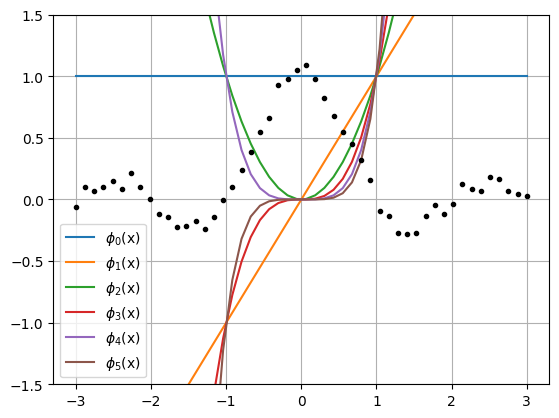

In [5]:
K = 5
Phi = poli_carac(X, K)
plot_caracteristicas(X, Phi, K)
plt.plot(X, y, '.k')

### Funciones exponenciales cuadráticas
En este caso, las funciones base $\phi_k(x)$ para $k = 1, 2, \cdots, K$ tienen la forma

$$
\phi_k(x) = \exp \left[- \frac{(\mu_k - x)^2}{\sigma^2} \right]
$$

In [6]:
def expo_carac(X, K):
    # Extraer caracteristicas exponenciales
    # X: N x D, vector de entradas
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi

    X = X.flatten()
    N = X.shape[0]

    #inicializar Phi
    Phi = np.ones((N, K+1))
    mu = np.linspace(0,50,K)
    sig2 = 0.1

    # Calcular matriz Phi
    for k in range(1, K+1):
        Phi[:,k] = np.exp(-(mu[k-1] - X)**2/sig2)
    return Phi

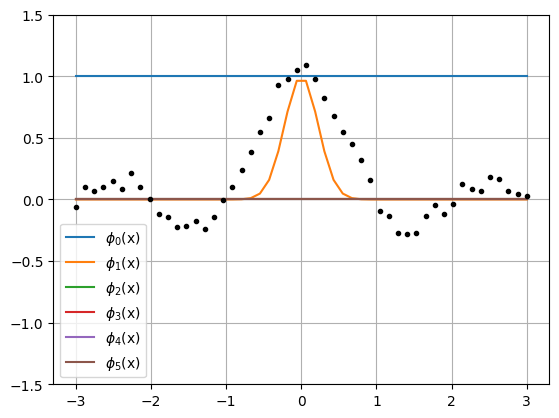

In [7]:
K = 5
Phi = expo_carac(X, K)
plot_caracteristicas(X, Phi, K)
plt.plot(X, y, '.k')

### Funciones base sinusoidales

En este caso, las funciones base $\phi_k(x)$ para $k = 1, 2, \cdots, K$ tienen la forma

$$
\phi_k(x) = \cos \left( \frac{2 \pi}{T_k}x \right),
$$

donde $T_k$ es el periodo de la función base.


In [8]:
def cos_carac(X, K):
    # Extraer caracteristicas sinusoidales
    # X: N x D, vector de entradas
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi

    X = X.flatten()
    N = X.shape[0]

    #inicializar Phi
    Phi = np.ones((N, K+1))
    F0= 1/6.0
    F = F0 * np.linspace(1, K, K)
    #print(1./F)

    # Calcular matriz Phi
    for k in range(1, K+1):
        Phi[:,k] = np.cos(2*np.pi*F[k-1]*X)
    return Phi

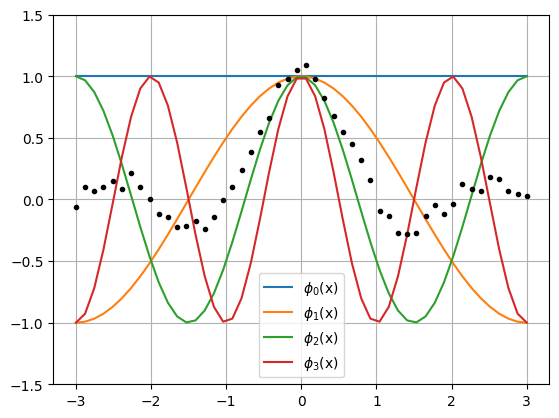

In [9]:
K = 3
Phi = cos_carac(X, K)
plot_caracteristicas(X, Phi, K)
plt.plot(X, y, '.k')

> **EJERCICIO 1:**
Utilice la definición de predicción vectorial
$$
\textbf{y} = \boldsymbol \Phi \boldsymbol \theta,
$$
 para muestrear tres funciones de forma aleatoria para cada uno de los tres tipos de funciones base (polinomial, exponencial, coseno). Asuma $K=5$.

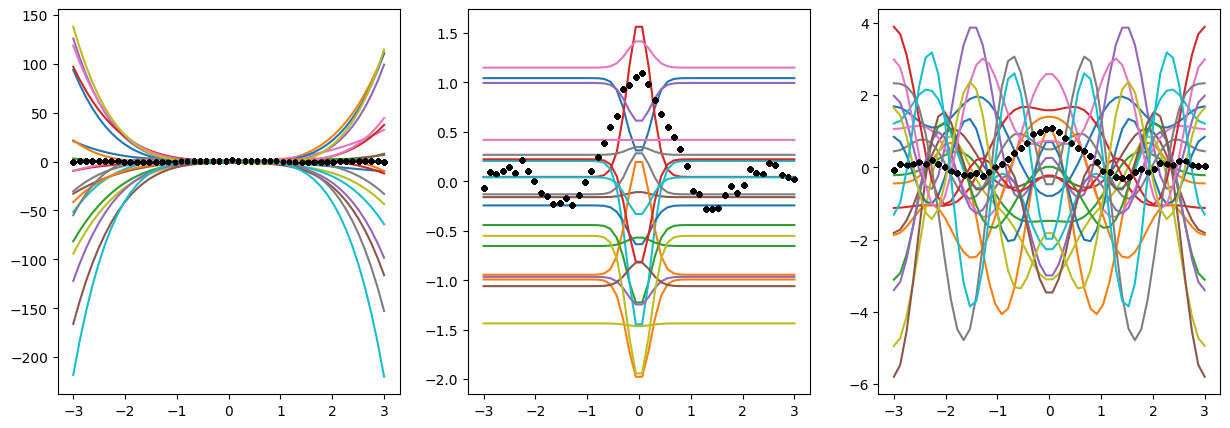

In [10]:
K = 4
Phi_poli = poli_carac(X, K)
Phi_expo = expo_carac(X, K)
Phi_cos = cos_carac(X, K)

plt.figure(figsize=(15,5))

for i in range(20):
  theta_random = np.random.normal(size=(K+1,1))
  #print(theta_random)

  y_poli = Phi_poli @ theta_random
  y_expo = Phi_expo @ theta_random
  y_cos = Phi_cos @ theta_random

  plt.subplot(1,3,1)
  plt.plot(X, y_poli)
  plt.plot(X, y, '.k')

  plt.subplot(1,3,2)
  plt.plot(X, y_expo)
  plt.plot(X, y, '.k')

  plt.subplot(1,3,3)
  plt.plot(X, y_cos)
  plt.plot(X, y, '.k')

---
# Inferencia
Por **inferencia** nos referimos a encontrar los parámetros $\boldsymbol \theta$ óptimos según alguna medida establecida conocida como **función objetivo**.

A continuación, presentamos dos formas de dividir un dataset en datos de *entrenamiento* y *test*. Es una práctica común utilizar el 70% de las observaciónes para entrenamiento (training), y el restante 30% para test. Esto nos permite evaluar el desempeño sobre datos que el modelo no conoce de antemano.

## Selección datos de entrenamiento

### Forma secuencial (extrapolar)

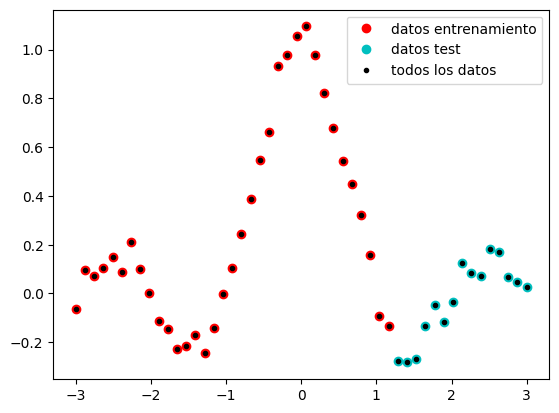

In [11]:
Xtrain = X[0:35] # 70% entrenamiento
ytrain = y[0:35]

Xtest = X[35:] # 30% test
ytest = y[35:]

plt.plot(Xtrain, ytrain, 'or')
plt.plot(Xtest, ytest, 'oc')
plt.plot(X, y, '.k')
plt.legend(['datos entrenamiento', 'datos test', 'todos los datos'])

### Forma aleatoria (interpolación)





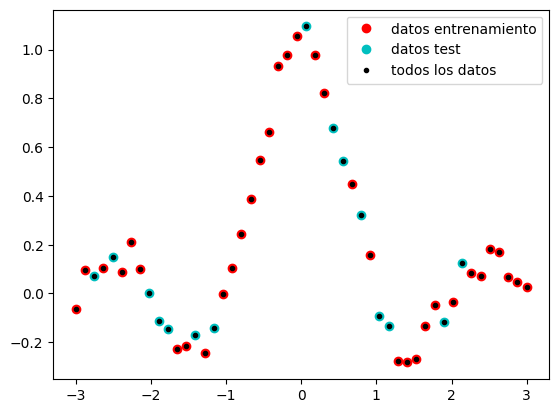

In [12]:
Xs, ys = skl.utils.shuffle(X, y)
Xtrain = Xs[0:35] # 70% entrenamiento
ytrain = ys[0:35]

Xtest = Xs[35:] # 30% test
ytest = ys[35:]

plt.plot(Xtrain, ytrain, 'or')
plt.plot(Xtest, ytest, 'oc')
plt.plot(X, y, '.k')
plt.legend(['datos entrenamiento', 'datos test', 'todos los datos'])


## Máxima verosimilitud
El enfoque de máxima verosimilitud consiste en encontrar los parámetros óptimos a través de la maximización de la verosimilitud de los datos observados. La **función objetivo** a maximizar corresponde a:

$$
p(\mathcal Y | \mathcal X, \boldsymbol\theta) = \prod_{n=1}^N p(y_n | \boldsymbol x_n, \boldsymbol\theta),
$$

En la práctica se minimiza el negativo del logaritmo de la verosimilitud

$$
-\log p(\mathcal Y | \mathcal X, \boldsymbol\theta) = -\sum_{n=1}^N \log p(y_n | \boldsymbol x_n, \boldsymbol\theta).
$$

El óptimo de esta función con respecto a los parámetros $\boldsymbol{\theta}$ se puede encontrar de forma cerrada y corresponde a la expresión

$$
\boldsymbol\theta^{\text{ML}} = (\textbf{ X}^\top \textbf{X})^{-1}\textbf{X}^\top\textbf{ y},
$$

donde $\boldsymbol\theta^{\text{ML}} \in\mathbb{R}^D$,

$$
\textbf{X} = [\boldsymbol x_1, \ldots, \boldsymbol x_N]^\top \in \mathbb{R}^{N\times D},
$$

$$
\textbf{y} = [y_1, \ldots, y_N]^\top \in\mathbb{R}^N\,.
$$


In [13]:
def plot_prediccion(X, prediccion):
  # Gráfica predicción

  plt.plot(Xtrain, ytrain, '.k')
  plt.plot(X, np.sinc(X), lw=2)
  plt.plot(X, prediccion, '--', lw=2)
  # plt.xlabel("$x$")
  # plt.ylabel("$y$")
  plt.legend(['datos entrenamiento', 'función real', 'predicción'])
  plt.ylim([-0.3, 1.1])

In [14]:
def inferencia_max_vero(X, y):
  # cálculo máxima verosimilitud
  # X: N x D, matriz de datos de entrada
  # y: N x 1, vector de observaciones salidas
  # return: D x 1, vector de parámetros estimados

  return np.linalg.solve(X.T @ X, X.T @ y)


### Inferencia usando extracción de caracteristicas

Si utilizamos funciones base (carácteristicas) los parámetros óptimos se calculan con la siguiente expresión

$$
\boldsymbol \theta^\text{ML} = (\boldsymbol\Phi^\top\boldsymbol\Phi)^{-1}\boldsymbol\Phi^\top \textbf{y}
$$

> Por motivos de estabilidad, es una práctica común adicionar un valor pequeño llamado "jitter" $\kappa>0$ en la diagonal de $\boldsymbol\Phi^\top\boldsymbol\Phi$, de manera que podamos invertir esta matriz sin problemas. Los parámetros óptimos se calculan de forma más estable con la expresión

$$
\boldsymbol \theta^\text{ML} = (\boldsymbol\Phi^\top\boldsymbol\Phi + \kappa\textbf{I})^{-1}\boldsymbol\Phi^\top \textbf{y}
$$

In [15]:
def inferencia_max_vero_carac(Phi, y):
    # máxima verosimilitud usando caracteristicas
    # Phi: N x D, caracteristicas
    # y: N x 1, datos de salida observados
    # return: D x 1, vector de parametros estimados

    kappa = 1e-09 # jitter
    D = Phi.shape[1]

    Pt = Phi.T @ y # Phi^T*y
    PP = Phi.T @ Phi + kappa*np.eye(D) # Phi^T*Phi + kappa*I
    C = sp.linalg.cho_factor(PP)
    theta_ml = sp.linalg.cho_solve(C, Pt) # inv(Phi^T*Phi)*Phi^T*y
    return theta_ml

---
# Predicción
Para hacer predicciones en los puntos de test $\textbf{X}_{\text{test}}$ es necesario aplicar primero las transformaciones sobre los datos de entrada $\boldsymbol\Phi_{\text{test}}= \boldsymbol\phi(\textbf{X}_{\text{test}})$, y posteriormente calcular la media predictiva $\textbf{y}^{\text{pred}}$ como

$$
\textbf{y}^{\text{pred}} = \boldsymbol \Phi_{\text{test}}\boldsymbol\theta^{\text{ML}}
$$

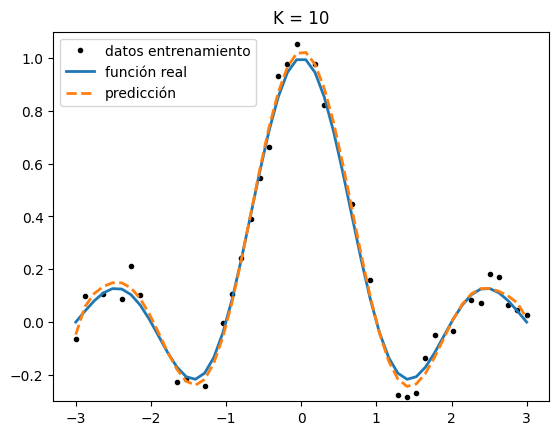

In [16]:
# selección y parametrización
K = 10 # grado del polinomio
Phi = poli_carac(Xtrain, K) # características datos entrenamiento

# inferencia usando max vero
theta_ml = inferencia_max_vero_carac(Phi, ytrain)


# predicción sobre todos los datos
Phi_test = poli_carac(X, K) # características todos los datos
y_pred = Phi_test @ theta_ml # predicción

# graficar resultados
plot_prediccion(X, y_pred)
plt.title('K = ' + str(K));

---
# Validación
En la etapa final de aprendizaje de máquina se evalua la calidad de las predicciónes del modelo.

## Evaluación cualitativa (visual)

Inicialmente podemos graficar las predicciones y compararlas con los datos de entrenamiento y test, evaluando visualmente que tan acertado es el modelo entrenado. Además, es muy necesario evaluar cuantitativamente el modelo obtenido. Para esto debe definirse una medida de error entre las predicciones y las observaciones.

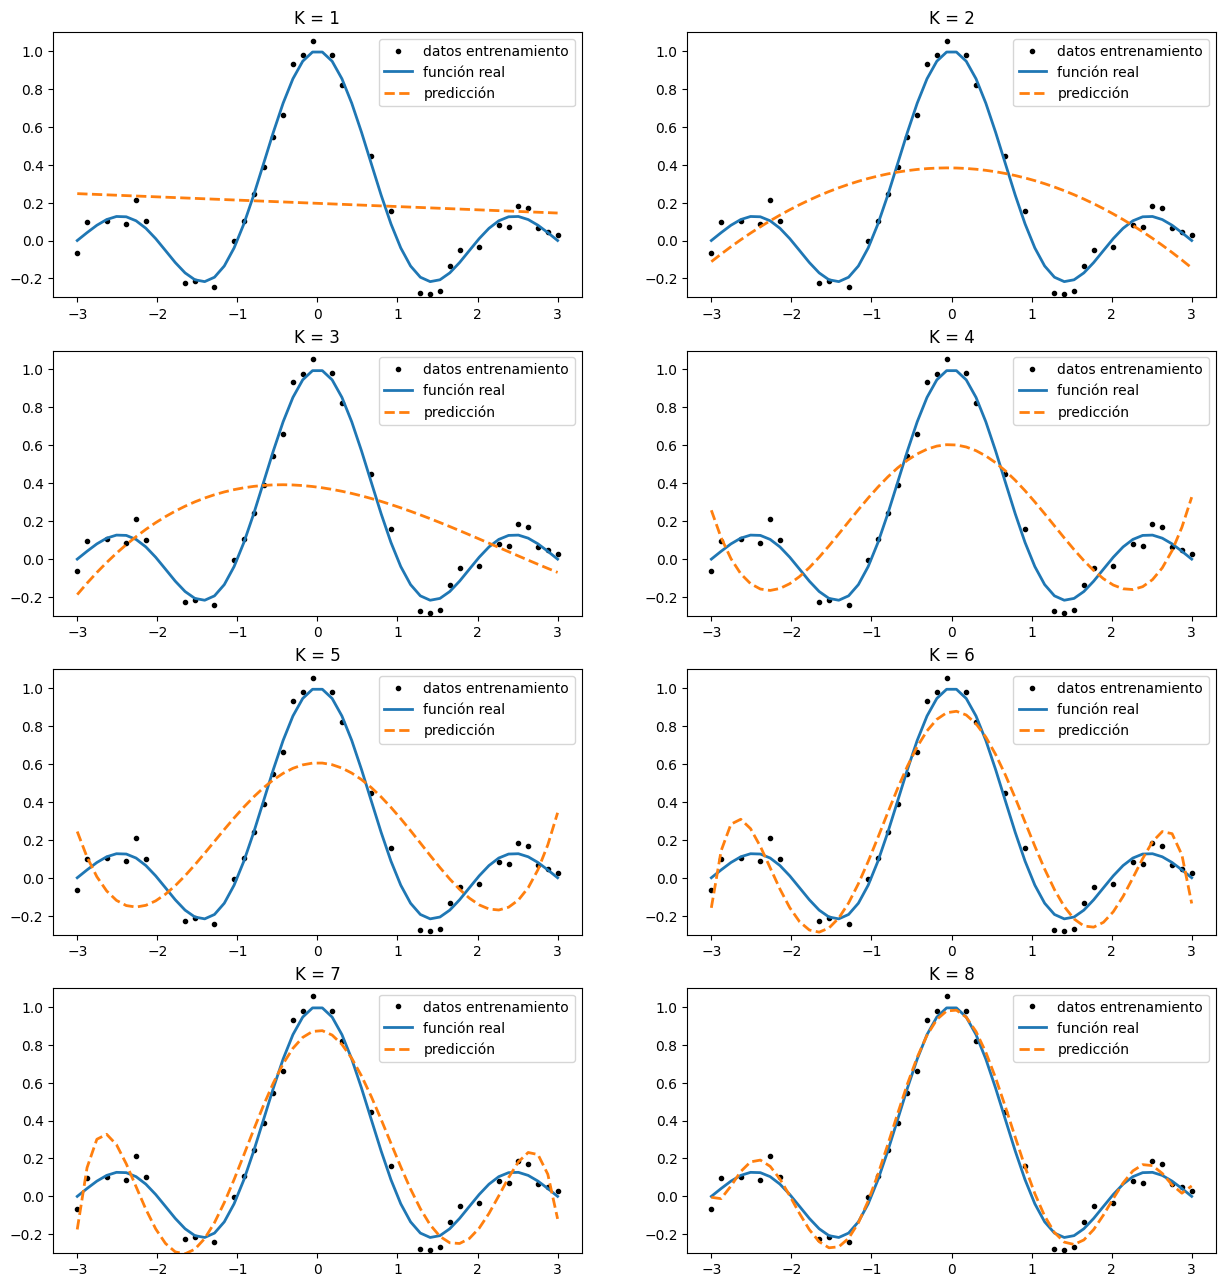

In [17]:
plt.figure(figsize=(15,20))
carac = poli_carac

for i in range(1, 9):
  # selección y parametrización
  K = i # grado del polinomio
  Phi = carac(Xtrain, K) # características datos entrenamiento

  # inferencia usando max vero
  theta_ml = inferencia_max_vero_carac(Phi, ytrain)

  # predicción sobre todos los datos (Test)
  Phi_test = carac(X, K) # características todos los datos
  y_pred = Phi_test @ theta_ml # predicción

  # graficar resultados
  plt.subplot(5,2,i)
  plot_prediccion(X, y_pred)
  plt.title('K = ' + str(K))

## Evaluación usando RMSE (cuantitativa)
A continuación, vamos a utilizar el RMSE como medida de error. Podemos calcular la calidad de las predicciones del modelo utilizando la raíz cuadrada del error cuadrático medio entre los valores predecidos por el modelo $ y_n^\text{pred}$, y los valores reales de la base de datos $y_n$, de manera que

$$
 \text{RMSE} = \sqrt{\frac{1}{N}\sum_{n=1}^N \left( y_n - y_n^\text{pred} \right)^2}
$$

RMSE significa root mean squared error (inglés).

> **EJERCICIO 2:**
implemente una función que calcule el RMSE. A continuación, para diferentes valores de $M$ grafique:
 - el error RMSE entre las predicciones `y_pred` y los datos de entrenamiento `y_train`.
 - el error RMSE entre las predicciones `y_pred` y los datos de test `y_test`.

In [18]:
def rmse(y, y_pred):
  # Calculo función de error
  y = y.flatten()
  y_pred = y_pred.flatten()
  N = y.shape[0]
  difer = (y - y_pred)**2
  return np.sqrt((1.0/N) * np.sum(difer))

A continuación haremos una evaluación cuantitativa de las predicciones obtenidas con diferentes modelos, cada uno definido con una cantidad diferente de funciones base $K$.

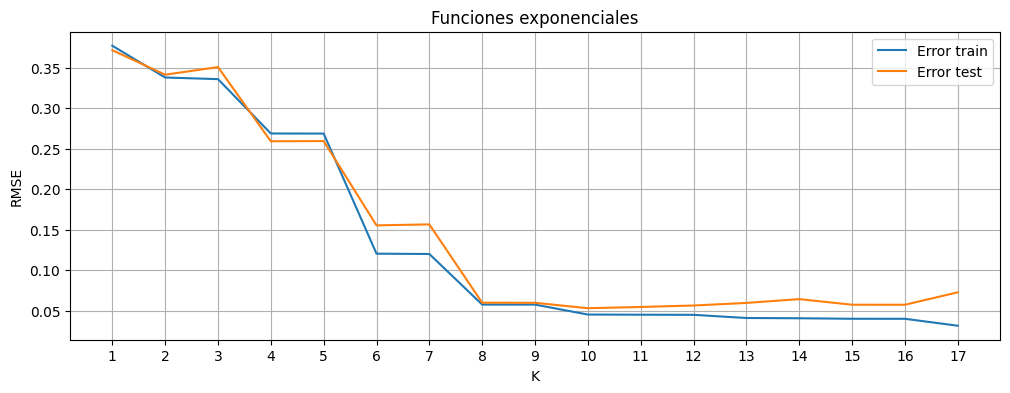

In [19]:
rmse_train = []
rmse_test = []
carac = poli_carac # seleccionar tipo de caracteristicas (poli, expo, cos)
K_max = 18 # cantidad máxima de caracteristicas

for i in range(1, K_max):
  # selección y parametrización
  K = i # grado del polinomio
  Phi = carac(Xtrain, K)

  # inferencia usando max vero
  theta_ml = inferencia_max_vero_carac(Phi, ytrain)

  # predicción sobre datos de entrenamiento
  Phi_test = carac(Xtrain, K)
  y_pred = Phi_test @ theta_ml # predicción
  rmse_train.append(rmse(ytrain, y_pred)) # medir error

  # predicción sobre datos de test
  Phi_test = carac(Xtest, K)
  y_pred = Phi_test @ theta_ml # predicción
  rmse_test.append(rmse(ytest, y_pred)) # medir error

# graficar errores
k_vector = np.linspace(1,K,K)

plt.figure(figsize=(12,4))
plt.plot(k_vector, rmse_train, '-', label='Error train')
plt.plot(k_vector, rmse_test, '-', label='Error test')
plt.xticks(k_vector);
plt.ylabel('RMSE')
plt.xlabel('K')
plt.title('Funciones exponenciales')
plt.legend()
plt.grid()

---
# Trabajo de laboratorio

Como trabajo de laboratorio vamos a entrenar un modelo de regresión para el caso **univariado** $y_n = f(x_n) + \epsilon$, donde la salida $ y_n∈ \mathbb{R}$, y la entrada $ x_n ∈ \mathbb{R}$. El procedimiento es el siguiente:

 1. Descargar una base de datos para regresión y visualizarla (por ejemplo buscar en https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets).

 2. Dividir la base de datos en 70% para entrenamiento y 30% para test, utilizando primero una partición aleatoria, y luego una partición secuencial. Graficar ambos tipos de particiones.

 3. Seleccione dos funciones base ya implementadas (por ejemplo: polinomial, exponencial, y coseno), y además implemente un nuevo tipo de función base que usted eliga, de manera que pueda definir tres modelos diferentes de regresión lineal.

A continuación, establezca la cantidad de funciones base $M$ necesarias para que el modelo se sobreentrene. Seguir el siguiente procedimiento para $M = 1, 2, \cdots, M_{\text{max}}$.

 4. Inferir los parámetros para cada modelo utilizando máxima verosimilitud.

 5. Grafique las predicciones de los modelos entrenados, junto con los datos de entrenamiento y test. Describa e interprete los resultados.

 5. Calcule el RMSE entre las predicciones de cada modelo `y_pred` y los datos de test `y_test`, así como el RMSE entre las predicciones de cada modelo `y_pred` y los datos de entrenamiento `y_train`. Grafique los errores (eje y) vs el número de caracteristicas (eje x). En base a estas gráficas establezca:
  - ¿qué modelo presenta mejor capacidad de generalización? argumente.

In [20]:
import seaborn as sns
import numpy as np, numpy
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(123)

Se toman los datos de la base de datos relacionada con las tomas de muestras del COVID en todos los paises del mundo, espcialmente se hace el laboratorio en los datos tomados del pais de Egypto

In [21]:
!wget 'https://covid.ourworldindata.org/data/owid-covid-data.csv' -O 'COVID_world.csv'

--2023-10-29 01:51:00--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 172.67.73.95, 104.26.2.153, 104.26.3.153, ...
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|172.67.73.95|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://covid-19.nyc3.digitaloceanspaces.com/public/owid-covid-data.csv [following]
--2023-10-29 01:51:00--  https://covid-19.nyc3.digitaloceanspaces.com/public/owid-covid-data.csv
Resolving covid-19.nyc3.digitaloceanspaces.com (covid-19.nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to covid-19.nyc3.digitaloceanspaces.com (covid-19.nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92287538 (88M) [binary/octet-stream]
Saving to: ‘COVID_world.csv’

COVID_world.csv     100%[===================>]  88.01M  30.1MB/s    in 2.9s    

2023-10-29 01:51:04 (30.1 

##Funciones

In [22]:
#Funcion para normalizar
def normalize_min_max(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

#Funcion para estandarizar
def estandarizar(datos):
    media = np.mean(datos)
    sigma = np.std(datos)
    datos_estandarizados = (datos - media) / sigma
    return datos_estandarizados

In [23]:
# Leemos el dataset de COVID con la libreria Pandas
dataCovid = pd.read_csv('COVID_world.csv')

posDataEgypt = dataCovid['location'].str.contains('Egypt')
dataCovidEgypt = dataCovid[posDataEgypt]
dataCovidEgypt[:10]

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
86315,EGY,Africa,Egypt,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,50.1,89.827,1.6,71.99,0.707,110990096.0,NaN,NaN,NaN,NaN
86316,EGY,Africa,Egypt,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,50.1,89.827,1.6,71.99,0.707,110990096.0,NaN,NaN,NaN,NaN
86317,EGY,Africa,Egypt,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,50.1,89.827,1.6,71.99,0.707,110990096.0,NaN,NaN,NaN,NaN
86318,EGY,Africa,Egypt,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,50.1,89.827,1.6,71.99,0.707,110990096.0,NaN,NaN,NaN,NaN
86319,EGY,Africa,Egypt,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,50.1,89.827,1.6,71.99,0.707,110990096.0,NaN,NaN,NaN,NaN
86320,EGY,Africa,Egypt,2020-01-08,NaN,0.0,0.0,NaN,0.0,0.0,...,50.1,89.827,1.6,71.99,0.707,110990096.0,NaN,NaN,NaN,NaN
86321,EGY,Africa,Egypt,2020-01-09,NaN,0.0,0.0,NaN,0.0,0.0,...,50.1,89.827,1.6,71.99,0.707,110990096.0,NaN,NaN,NaN,NaN
86322,EGY,Africa,Egypt,2020-01-10,NaN,0.0,0.0,NaN,0.0,0.0,...,50.1,89.827,1.6,71.99,0.707,110990096.0,NaN,NaN,NaN,NaN
86323,EGY,Africa,Egypt,2020-01-11,NaN,0.0,0.0,NaN,0.0,0.0,...,50.1,89.827,1.6,71.99,0.707,110990096.0,NaN,NaN,NaN,NaN
86324,EGY,Africa,Egypt,2020-01-12,NaN,0.0,0.0,NaN,0.0,0.0,...,50.1,89.827,1.6,71.99,0.707,110990096.0,NaN,NaN,NaN,NaN


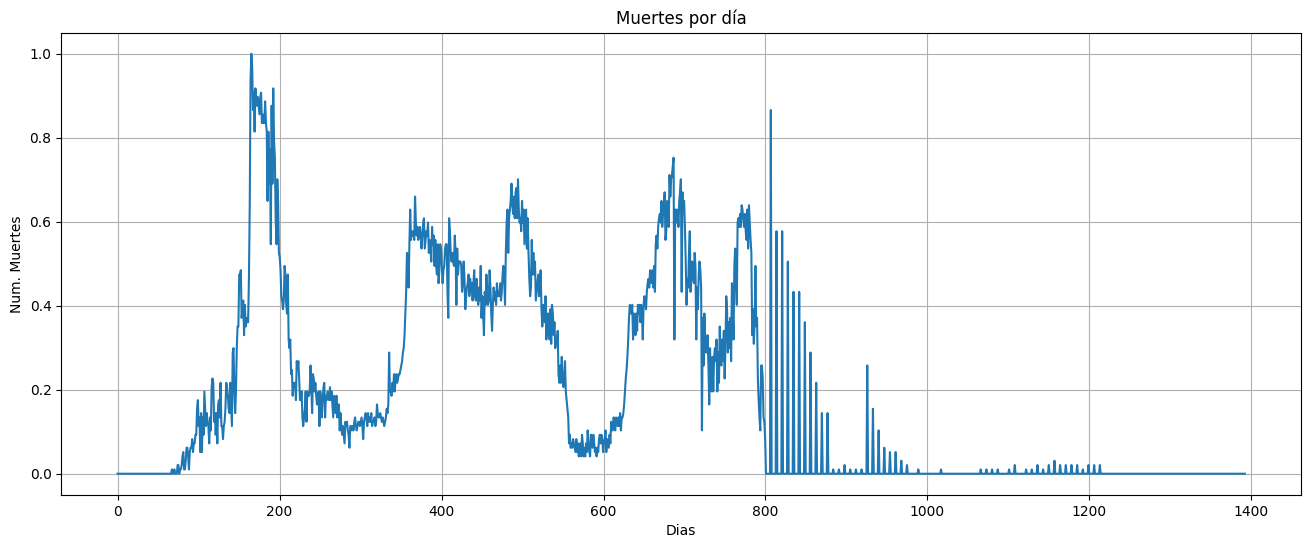

1392
1392


In [24]:
fecha = dataCovidEgypt['date']
N = np.shape(np.ravel(fecha))
N = N[0]
x = np.linspace(0,N,N)
X = np.nan_to_num(x)

new_deaths = dataCovidEgypt['new_deaths']
new_deaths_N = normalize_min_max(new_deaths)
Datos = np.nan_to_num(new_deaths_N, nan=0.0)

plt.figure(figsize=(16,6))
plt.plot(X,Datos)
plt.xlabel('Dias')
plt.ylabel('Num. Muertes')
plt.title('Muertes por día')
plt.grid()
plt.show()
#dataCovidCHINA[:10]
#print(new_deaths.max())
print(len(x))
print(len(new_deaths_N))

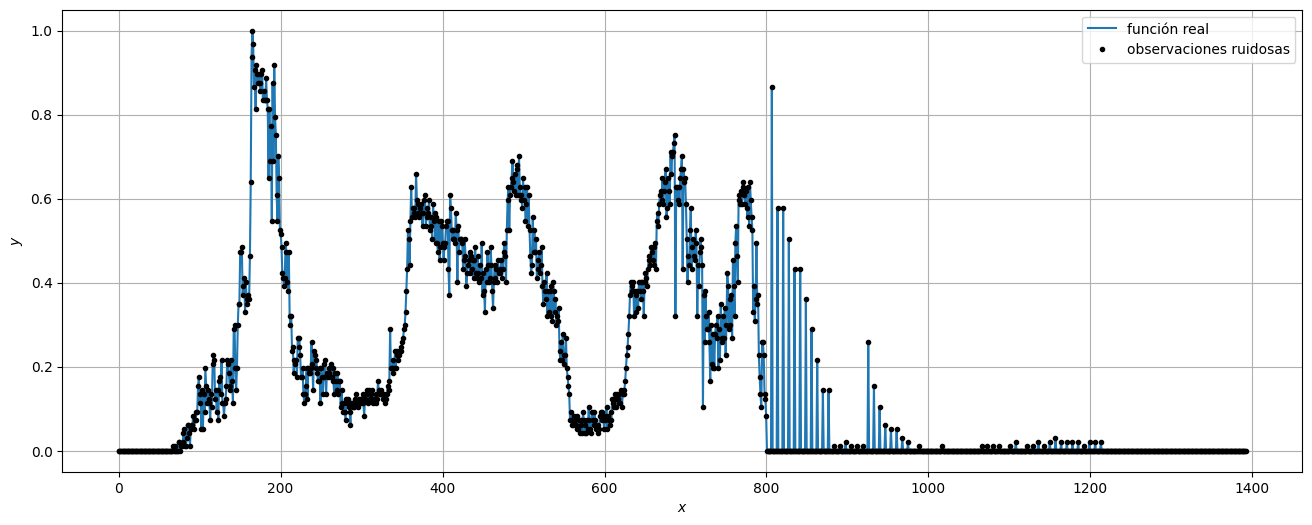

In [25]:
Datos = np.array(Datos)
X = np.array(X)

# Visualización de los datos originales y transformados
plt.figure(figsize=(16,6))
plt.plot(X, Datos, label='función real')
plt.plot(X, Datos, '.k', label='observaciones ruidosas')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.grid()
plt.show()

### Forma secuencial (extrapolar)

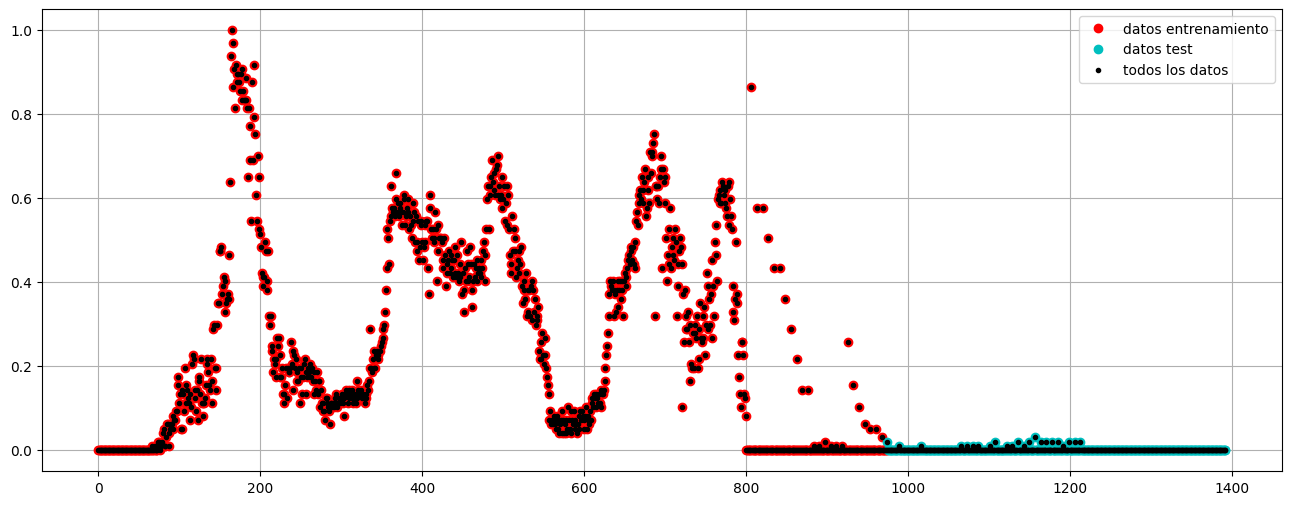

In [26]:
porcion = int(len(X)*0.7)
Xtrain_sec = X[0:porcion] # 70% entrenamiento
ytrain_sec = Datos[0:porcion]

Xtest_sec = X[porcion:] # 30% test
ytest_sec = Datos[porcion:]

plt.figure(figsize=(16,6))
plt.plot(Xtrain_sec, ytrain_sec, 'or')
plt.plot(Xtest_sec, ytest_sec, 'oc')
plt.plot(X, Datos, '.k')
plt.grid()
plt.legend(['datos entrenamiento', 'datos test', 'todos los datos'])

### Forma aleatoria (interpolacion)

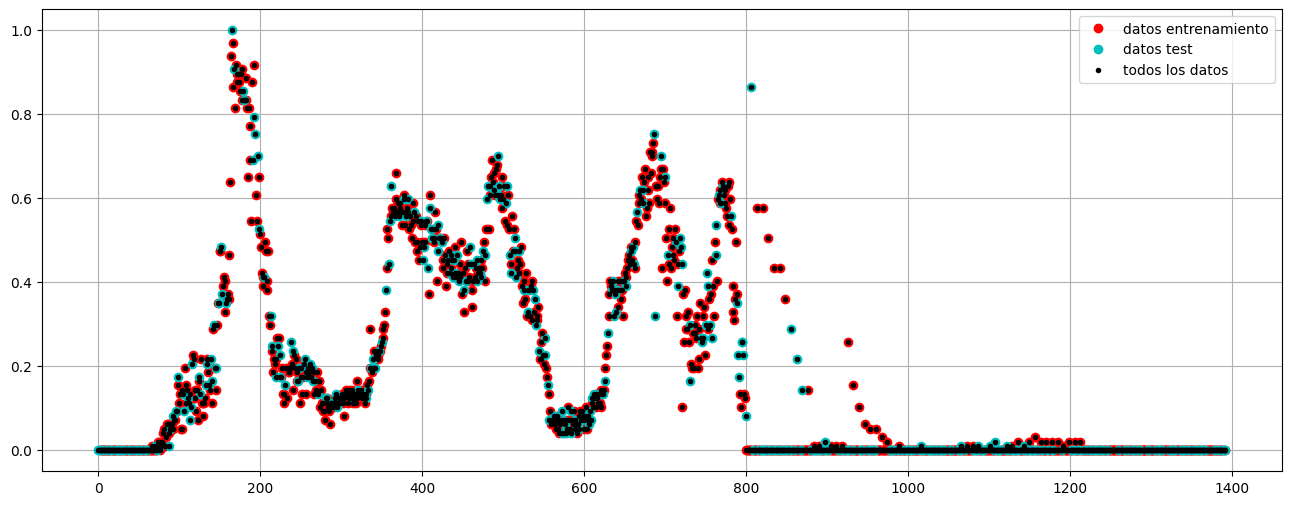

In [27]:
Xs, ys = skl.utils.shuffle(X, Datos)
Xtrain = Xs[0:porcion] # 70% entrenamiento
ytrain = ys[0:porcion]

Xtest = Xs[porcion:] # 30% test
ytest = ys[porcion:]

plt.figure(figsize=(16,6))
plt.plot(Xtrain, ytrain, 'or')
plt.plot(Xtest, ytest, 'oc')
plt.plot(X, Datos, '.k')
plt.grid()
plt.legend(['datos entrenamiento', 'datos test', 'todos los datos'])

##Implementacion de las funciones base Polinomial,exponencial, coseno y sigmoidal

In [28]:
def poli_carac(X, K):
    # Extraer caracteristicas polinomiales
    # X: N x D, vector de entradas
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi

    X = X.flatten()
    N = X.shape[0]

    #inicializar Phi
    Phi = np.zeros((N, K+1))

    # Calcular matriz Phi
    for k in range(K+1):
        Phi[:,k] = X**k
    return Phi

def plot_caracteristicas(X, Phi, K):
    legend = []
    for i in range(K+1):
      plt.plot(X, Phi[:, i])
      legend.append(r'$\phi_' + str(i) +'$(x)')
    plt.legend(legend);
    #plt.ylim([-3, 3])
    plt.grid(True)

def expo_carac(X, K):
    # Extraer caracteristicas exponenciales
    # X: N x D, vector de entradas
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi

    X = X.flatten()
    N = X.shape[0]

    #inicializar Phi
    Phi = np.ones((N, K+1))
    mu = np.linspace(0,1392,K)
    sig2 = 0.0001

    # Calcular matriz Phi
    for k in range(1, K+1):
        Phi[:,k] = np.exp(-((X - mu[k-1])**2/2*sig2))
    return Phi

def cos_carac(X, K):
    # Extraer caracteristicas sinusoidales
    # X: N x D, vector de entradas
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi

    X = X.flatten()
    N = X.shape[0]

    #inicializar Phi
    Phi = np.ones((N, K+1))
    F0= 1/1392
    F = F0 * np.linspace(1, K, K)
    #print(1./F)

    # Calcular matriz Phi
    for k in range(1, K+1):
        Phi[:,k] = np.cos(2*np.pi*F[k-1]*X)
    return Phi

def sigmo_carac(X, K): # FUNCIÓN BASE SIGMOIDE

    X = X.flatten()
    N = X.shape[0]
    s = 100
    #inicializar Phi
    Phi = np.ones((N, K+1))
    mu = np.linspace(0,1392,K)
    # Calcular matriz Phi
    for k in range(1,K+1):
      a=((X - mu[k-1])/np.sqrt(s))
      Phi[:,k] = 1/(1 + np.exp(-a))
    return Phi

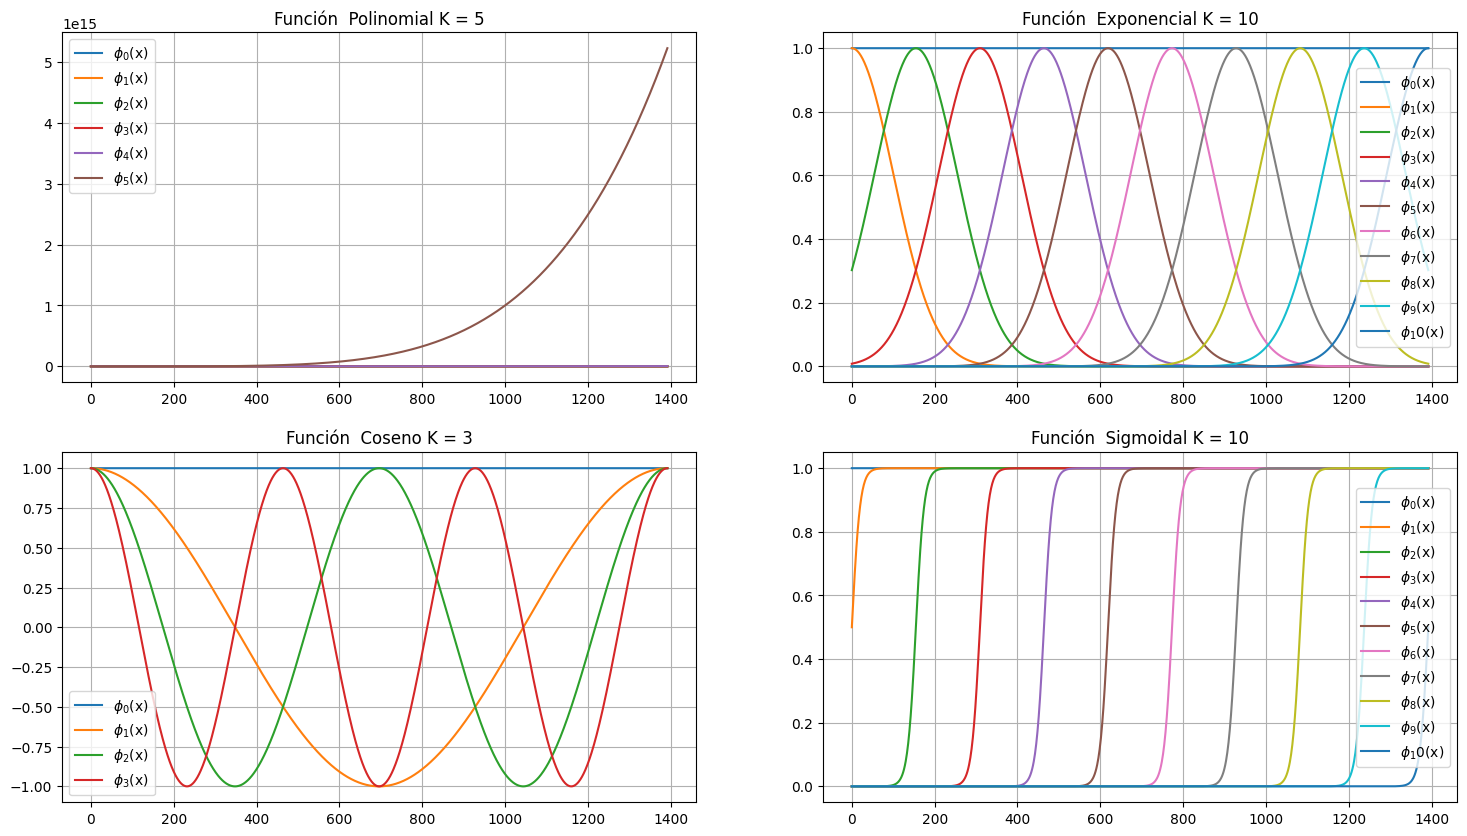

In [29]:
K1 = 3
K2 = 10
K3 = 10
K4 = 5
Phi_cos = cos_carac(X, K1)
Phi_expo = expo_carac(X, K2)
Phi_sigmo = sigmo_carac(X, K3)
Phi_poli = poli_carac(X,K4)

plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
plot_caracteristicas(X, Phi_poli, K4)
plt.title('Función  Polinomial K = ' + str(K4));
#plt.plot(X, Datos, '.k')

plt.subplot(2,2,2)
plot_caracteristicas(X, Phi_expo, K2)
plt.title('Función  Exponencial K = ' + str(K2));
#plt.plot(X, Datos, '.k')

plt.subplot(2,2,3)
plot_caracteristicas(X, Phi_cos, K1)
plt.title('Función  Coseno K = ' + str(K1));
#plt.plot(X, Datos, '.k')

plt.subplot(2,2,4)
plot_caracteristicas(X, Phi_sigmo, K3)
plt.title('Función  Sigmoidal K = ' + str(K3));
#plt.plot(X, Datos, '.k')

plt.show()

##4. Maxima Verosimilitud

In [46]:
#Funciones

def inferencia_max_vero_carac(Phi, y):
    # máxima verosimilitud usando caracteristicas
    # Phi: N x D, caracteristicas
    # y: N x 1, datos de salida observados
    # return: D x 1, vector de parametros estimados

    kappa = 1e-09 # jitter
    D = Phi.shape[1]

    Pt = Phi.T @ y # Phi^T*y
    PP = Phi.T @ Phi + kappa*np.eye(D) # Phi^T*Phi + kappa*I
    C = sp.linalg.cho_factor(PP)
    theta_ml = sp.linalg.cho_solve(C, Pt) # inv(Phi^T*Phi)*Phi^T*y
    return theta_ml
def plot_prediccion(X, prediccion):
    # Gráfica predicción

    plt.plot(Xtrain, ytrain, '.k')
    plt.plot(X, Datos, lw=2)
    plt.plot(X, prediccion, '--', lw=2)
    plt.legend(['datos entrenamiento', 'función real', 'predicción'])


In [47]:
#Funcion para sacar todas las verosimilitudes
def max_vero(funcion,Xtrain,ytrain,tipo):
  plt.figure(figsize=(18,5))

  if funcion == poli_carac:
    K=[8,10,11]
  else:
    K=[10,50,200]

  for i in range(3):
    Phi_poli = funcion(Xtrain, K[i]) # características datos entrenamiento
    # inferencia usando max vero
    theta_ml_poli = inferencia_max_vero_carac(Phi_poli, ytrain)
    # predicción sobre todos los datos
    Phi_test_poli = funcion(X, K[i]) # características todos los datos
    y_pred_poli = Phi_test_poli @ theta_ml_poli # predicción


    plt.subplot(1,3,i+1)
    plot_prediccion(X, y_pred_poli)
    plt.title('Predicción ' + tipo + ' K = ' + str(K[i]))
    plt.grid()

###Grafica con aprticion aleatoria

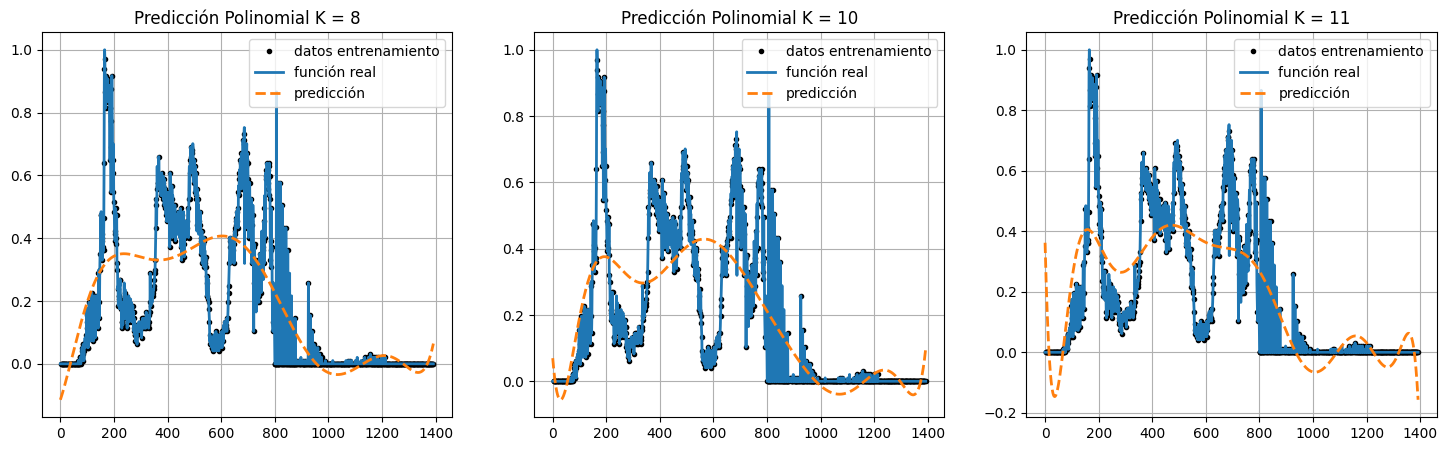

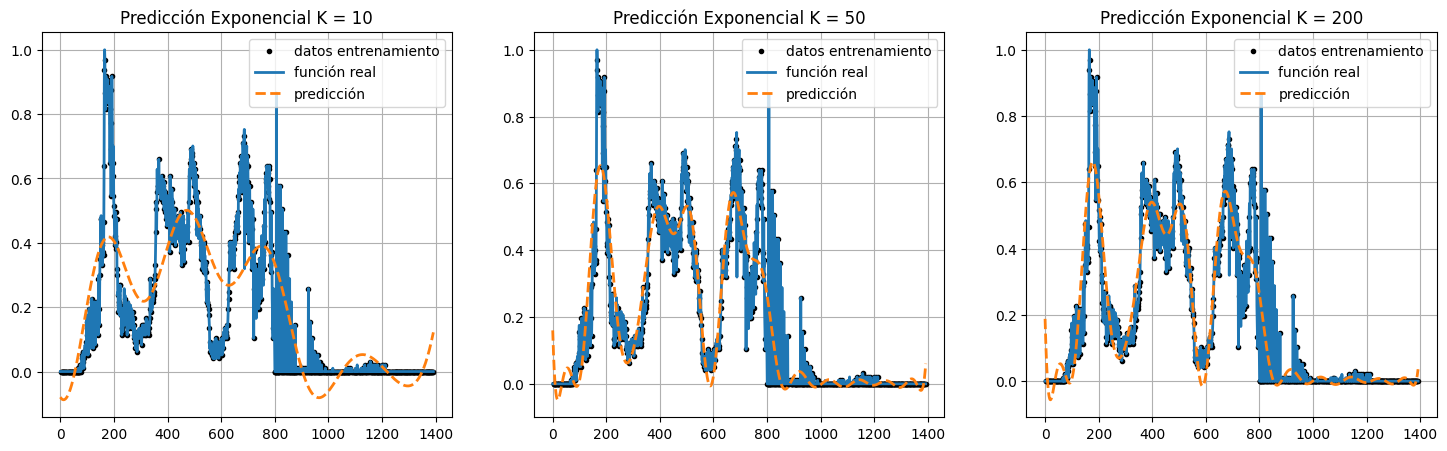

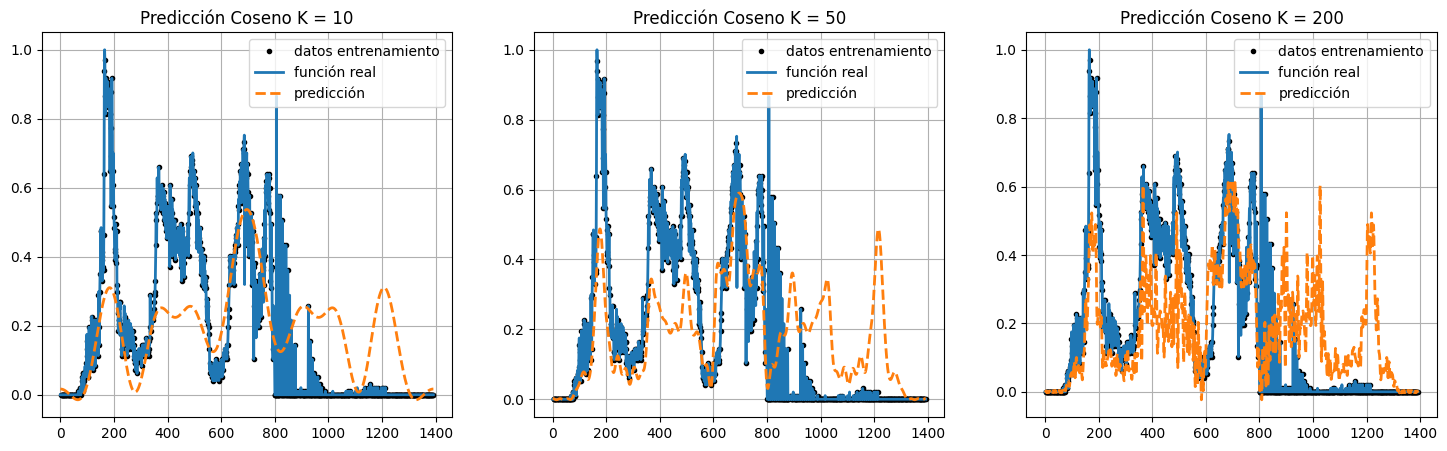

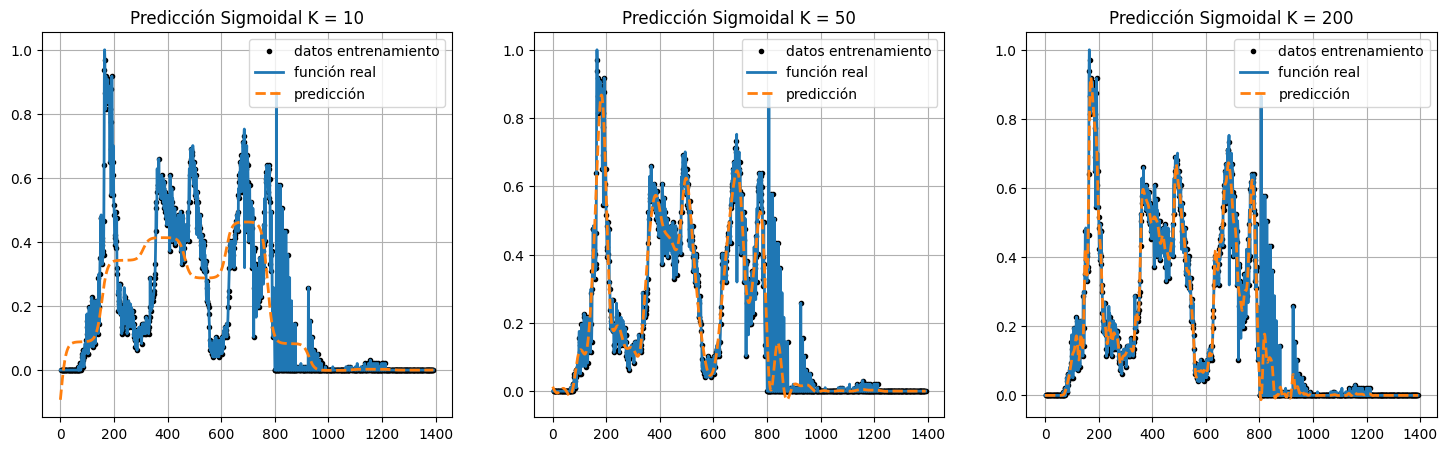

In [32]:
max_vero(poli_carac,Xtrain,ytrain,'Polinomial')
max_vero(expo_carac,Xtrain,ytrain,'Exponencial')
max_vero(cos_carac,Xtrain,ytrain,'Coseno')
max_vero(sigmo_carac,Xtrain,ytrain,'Sigmoidal')

- La función sigmoidal destaca como la opción con el mejor desempeño en este análisis. Una de sus ventajas notables es su capacidad para aproximar con precisión puntos que están alejados entre sí. Esto significa que puede capturar tendencias y patrones en los datos de manera efectiva, incluso cuando los puntos de datos se encuentran en extremos opuestos.

- La función exponencial también demuestra tener una capacidad de predicción sólida para los datos. Su rendimiento está fuertemente influenciado por la variabilidad en los datos, ya que un valor pequeño para esta variable resulta en una aproximación más significativa. Sin embargo, es importante destacar que aún pueden surgir errores considerables.

- Por otro lado, la función coseno y la función polinomial muestran errores notables en su capacidad de predicción. Ambas funciones pueden tener dificultades para capturar cambios bruscos en ciertos períodos de los datos y para identificar valores atípicos. Estas funciones pueden no ser las elecciones más adecuadas cuando se requiere un alto grado de precisión en la regresión, especialmente en situaciones donde los datos presentan cambios abruptos o valores inusuales.

Estas observaciones subrayan la importancia de seleccionar la función de regresión adecuada en función de las características específicas de los datos y las necesidades de predicción. La función sigmoidal y la exponencial destacan como opciones sólidas, mientras que la función coseno y la polinomial pueden no ser las más adecuadas para capturar ciertos comportamientos de los dato

###Graficas con particiones secuencial

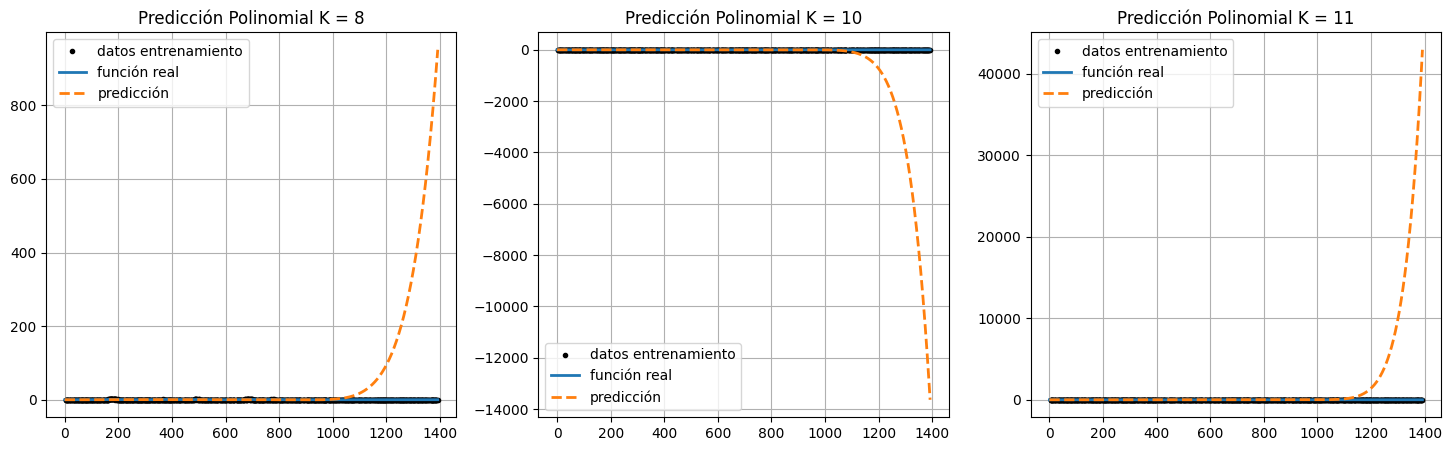

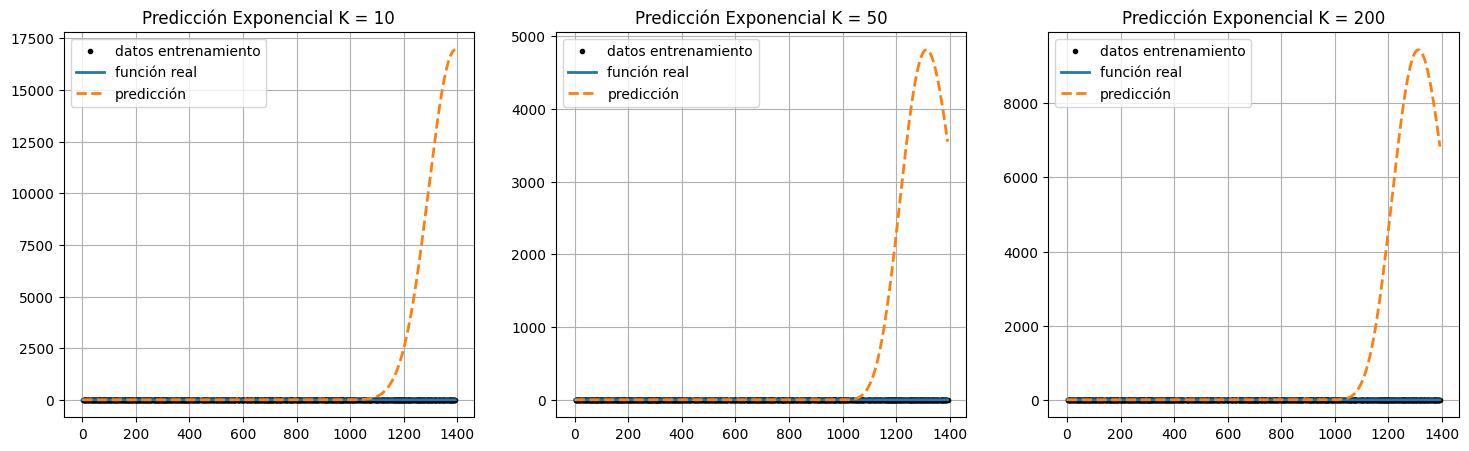

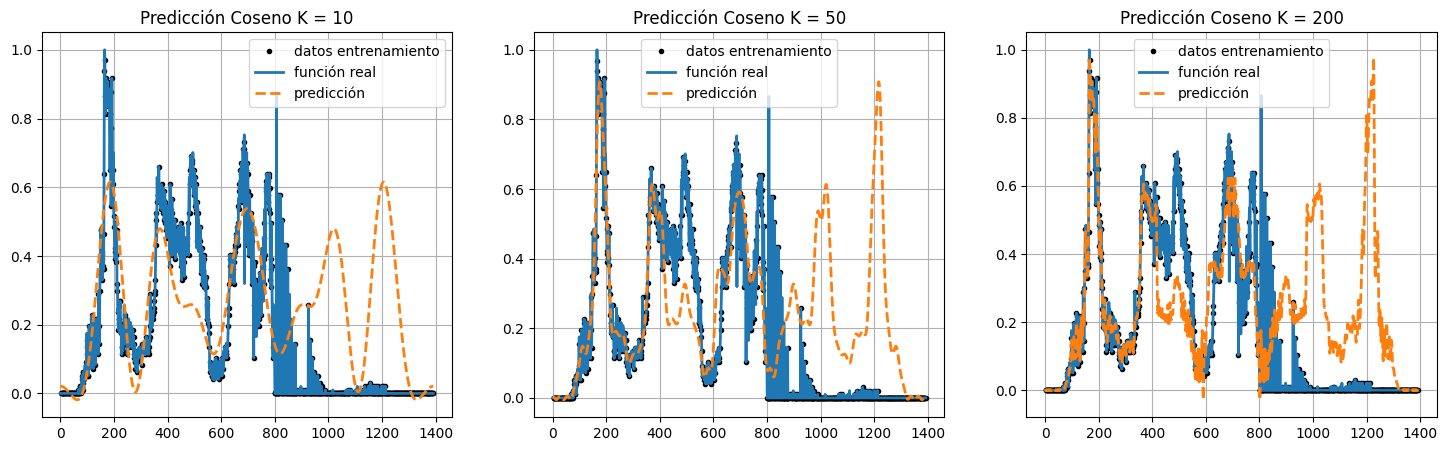

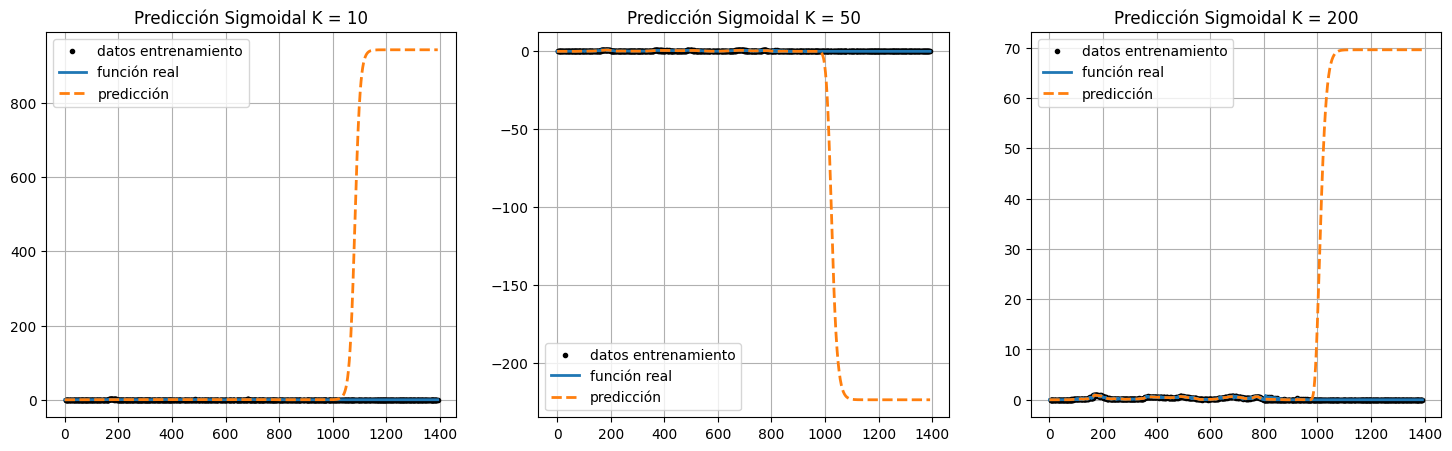

In [48]:
max_vero(poli_carac,Xtrain_sec,ytrain_sec,'Polinomial')
max_vero(expo_carac,Xtrain_sec,ytrain_sec,'Exponencial')
max_vero(cos_carac,Xtrain_sec,ytrain_sec,'Coseno')
max_vero(sigmo_carac,Xtrain_sec,ytrain_sec,'Sigmoidal')

En este escenario particular, es importante considerar el impacto de tomar solo los datos de las particiones secuenciales, excluyendo la zona de test que es el 30% final del conjunto de datos. Esta exclusión puede resultar en un comportamiento diferente de las funciones de regresión, ya que no tienen en cuenta esa parte final de los datos. Al analizar este escenario, observamos que el comportamiento de las funciones se ajusta de manera más precisa a los datos disponibles en este subconjunto, llevando la predicción al límite.

Sin embargo, es fundamental destacar que, en este contexto, las funciones sigmoidal y exponencial se destacan como las opciones más efectivas para realizar estas predicciones. Estas funciones logran capturar de manera óptima el comportamiento de los datos dentro de las particiones secuenciales. Su capacidad para modelar patrones y tendencias en estos datos hace que sean las elecciones preferidas para obtener predicciones precisas en este escenario específico.

##RMSE



In [60]:
def rmse_k(carac,K_max,titulo,Xtrain,ytrain,Xtest,ytest):

  rmse_train = []
  rmse_test = []
  K_vector = []
  #carac = expo_carac # seleccionar tipo de caracteristicas (trigo, expo, sigmo)

  if K_max <= 10:
    cons=1
  else:
    cons=10

  for i in range(1, K_max,cons):
    K = i

    Phi_train = carac(Xtrain, K)
    theta_ml = inferencia_max_vero_carac(Phi_train, ytrain)

    y_pred = Phi_train @ theta_ml # predicción
    rmse_train.append(rmse(ytrain, y_pred)) # medir error

    # predicción sobre datos de test
    Phi_test = carac(Xtest, K)
    y_pred = Phi_test @ theta_ml # predicción
    rmse_test.append(rmse(ytest, y_pred)) # medir error

    K_vector.append(i)

  plt.figure(figsize=(15,4))
  plt.plot(K_vector, rmse_train, '-', label='Error train')
  plt.plot(K_vector, rmse_test, '-', label='Error test')
  plt.xticks(K_vector);
  plt.ylabel('RMSE')
  plt.xlabel('K')
  plt.title(titulo)
  plt.legend()

###RMSE para la prediccion con particiones aleatoria

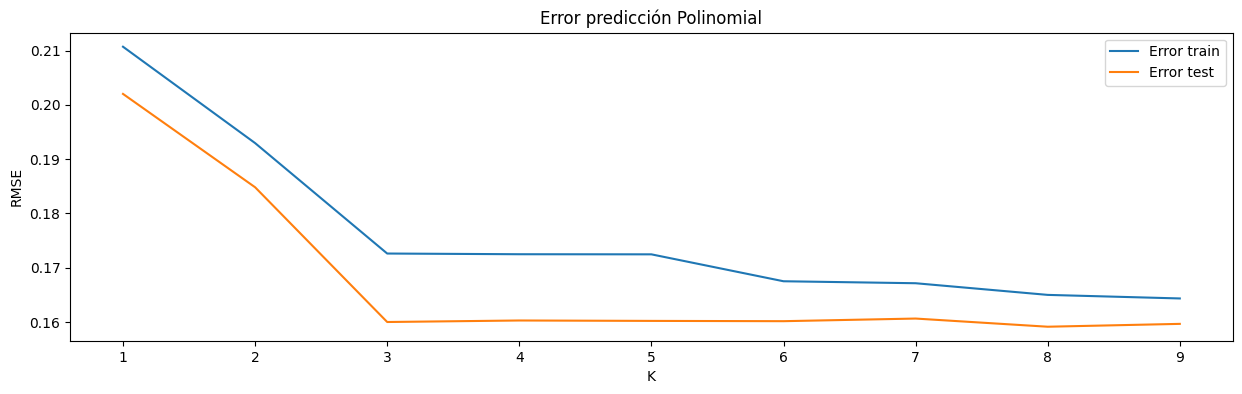

In [61]:
rmse_k(poli_carac,10,'Error predicción Polinomial',Xtrain,ytrain,Xtest,ytest)

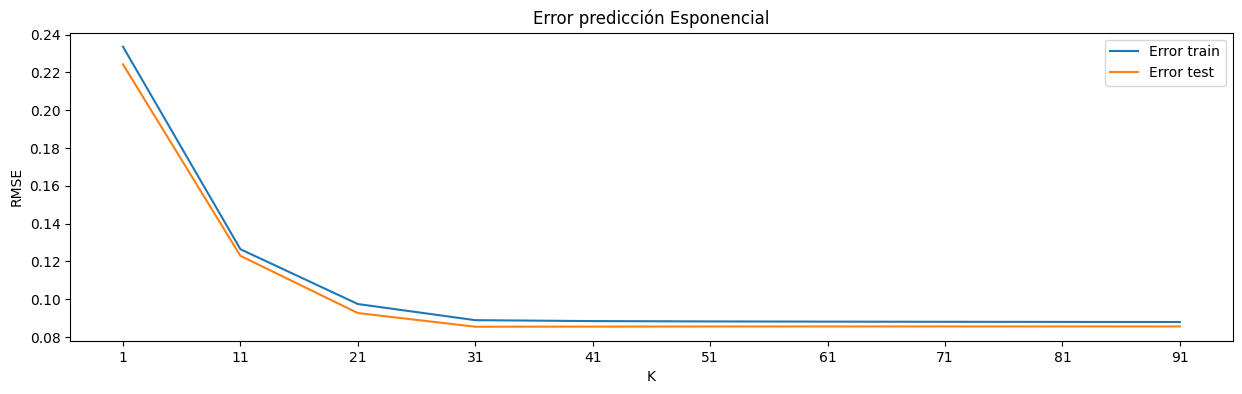

In [64]:
rmse_k(expo_carac,100,'Error predicción Esponencial',Xtrain,ytrain,Xtest,ytest)

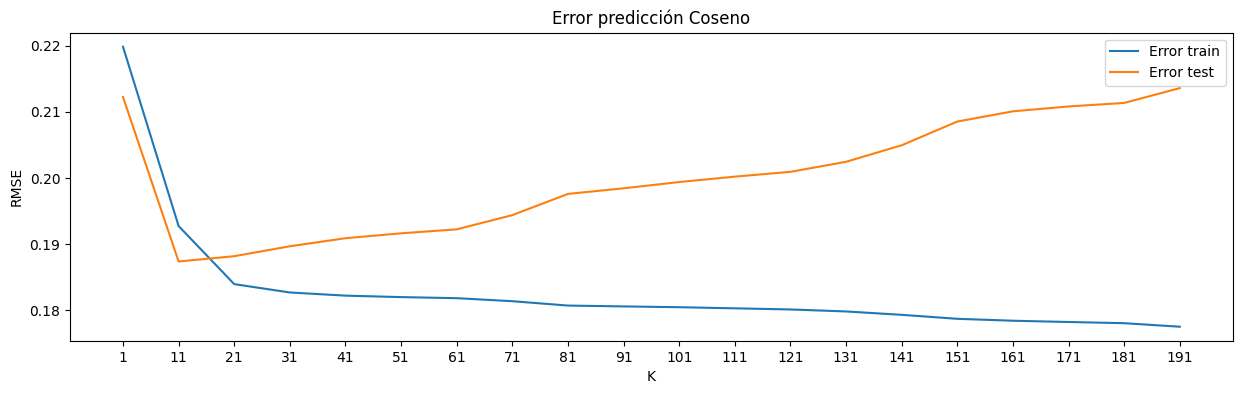

In [65]:
rmse_k(cos_carac,200,'Error predicción Coseno',Xtrain,ytrain,Xtest,ytest)

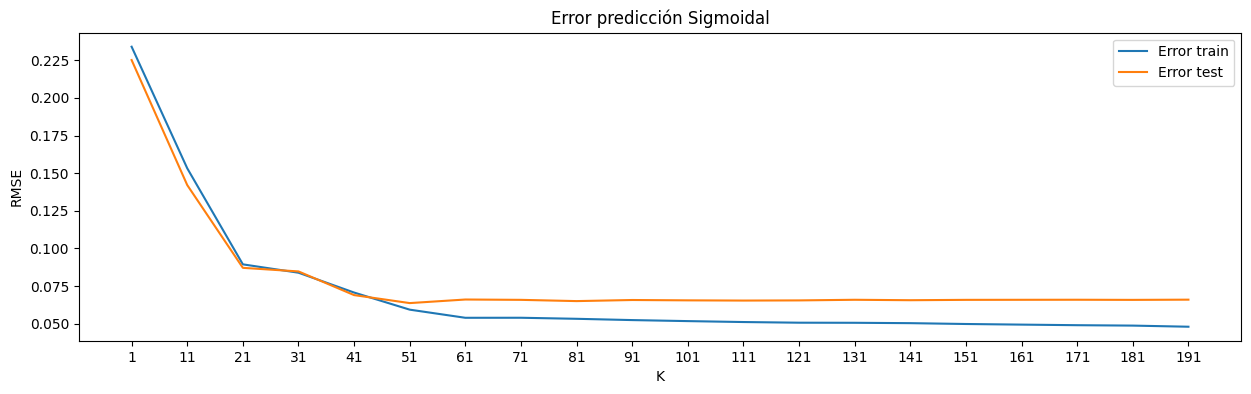

In [66]:
rmse_k(sigmo_carac,200,'Error predicción Sigmoidal',Xtrain,ytrain,Xtest,ytest)

###RMSE para la prediccion con particion secuencial

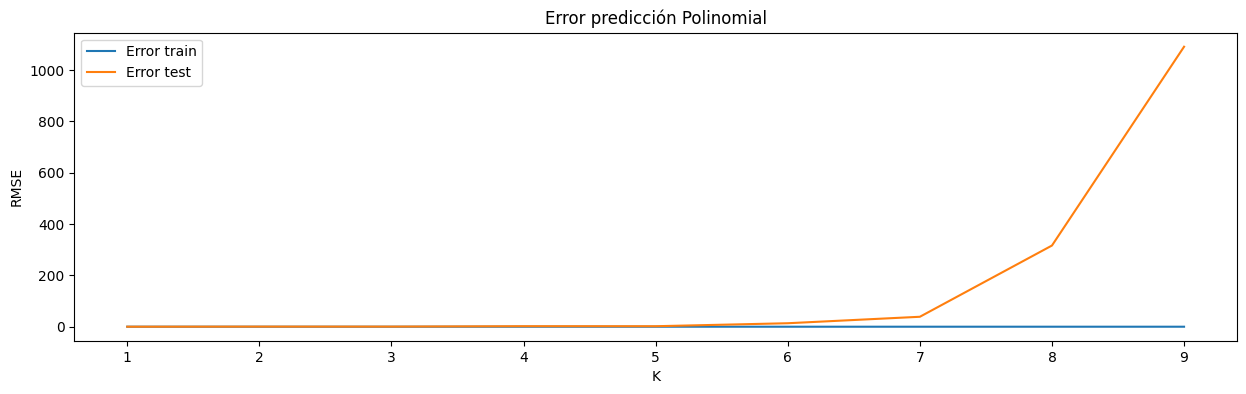

In [67]:
rmse_k(poli_carac,10,'Error predicción Polinomial',Xtrain_sec,ytrain_sec,Xtest_sec,ytest_sec)

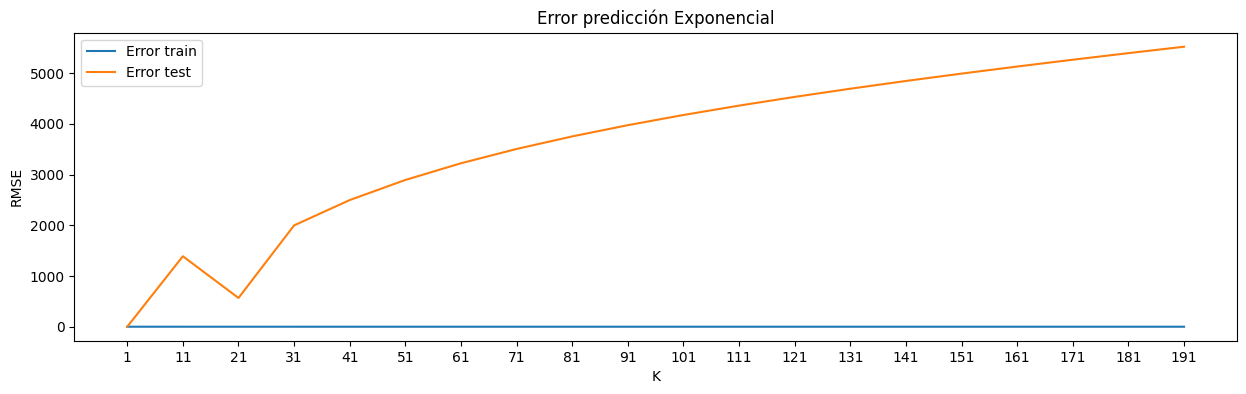

In [68]:
rmse_k(expo_carac,200,'Error predicción Exponencial',Xtrain_sec,ytrain_sec,Xtest_sec,ytest_sec)

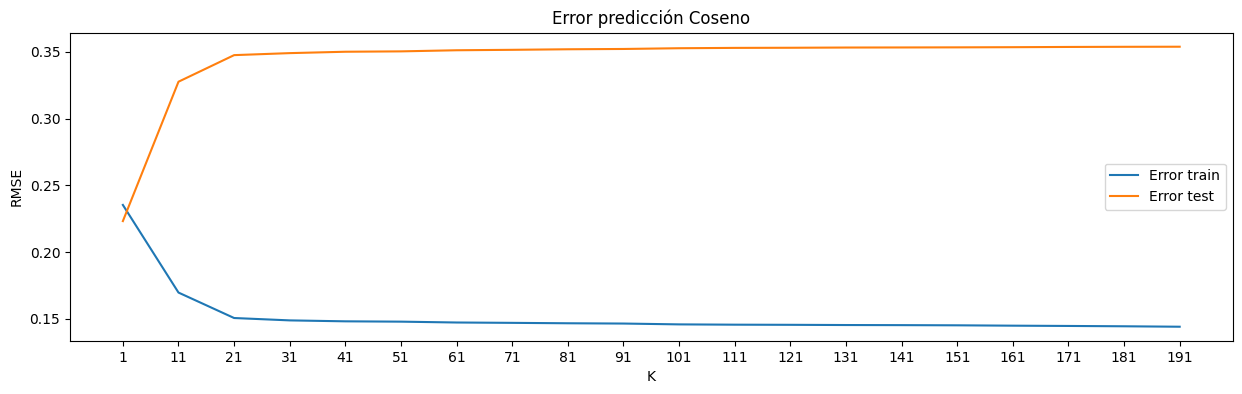

In [70]:
rmse_k(cos_carac,200,'Error predicción Coseno',Xtrain_sec,ytrain_sec,Xtest_sec,ytest_sec)

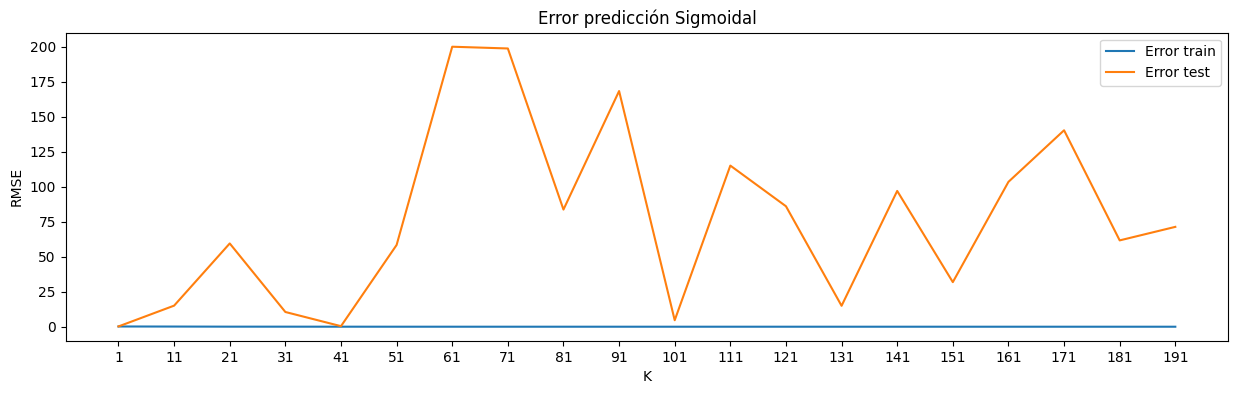

In [71]:
rmse_k(sigmo_carac,200,'Error predicción Sigmoidal',Xtrain_sec,ytrain_sec,Xtest_sec,ytest_sec)

##Conclusiones

- El análisis previo revela que los modelos con una mayor capacidad de generalización en la partición aleatoria son el exponencial y el sigmoidal. Esto se debe a su comportamiento, que se limita a dar relevancia a los valores cercanos a la media o al centro, lo que resulta en una sólida capacidad de predicción en diferentes puntos o regiones de la señal.

- Por otro lado, en el caso de la partición secuencial, la función que muestra un mejor comportamiento es la del coseno. Esto puede relacionarse con la naturaleza periódica de la señal en esta partición, lo que permite que la matriz "Phi" contenga valores que, aunque no sean precisos, se asemejan más a los obtenidos con las otras funciones base.

- Además, es importante notar que la función trigonométrica también puede ofrecer un buen rendimiento si se aplica regularización. Esto ayuda a evitar que, al aumentar el número de funciones base, los valores de los pesos sean demasiado grandes y provoquen un sobreajuste.

Se resalta la importancia de contar con una variedad de funciones base y ser capaz de elegir la más adecuada según el contexto de trabajo. Al disponer de diferentes funciones base y probarlas con una base de datos, es posible mejorar significativamente los resultados de la regresión lineal, ya que cada función puede sobresalir en escenarios particulares.

---
# Bibliografía

- Pattern Recognition and Machine Learning, Christopher M. Bishop. https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf (libro original gratis).

- Mathematics for Machine Learning, Marc Peter Deisenroth. https://mml-book.github.io/ (libro original gratis).

- Cuadernos del libro: Mathematics for Machine Learning. https://nbviewer.org/github/mml-book/mml-book.github.io/blob/master/tutorials/tutorial_linear_regression.ipynb